# Chapter 14: Productionalizing Prophet

## Saving a model

In [1]:
import pandas as pd
from prophet import Prophet
import json
from prophet.serialize import model_to_json, model_from_json

c:\users\gregr\appdata\local\programs\python\python38\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
df = pd.read_csv('../data/baltimore_crime.csv')
df.columns = ['ds', 'y']
df.loc[df['y'] > 250, 'y'] = None

model = Prophet()
model.fit(df)

18:33:49 - cmdstanpy - INFO - Chain [1] start processing
18:33:54 - cmdstanpy - INFO - Chain [1] done processing


In [3]:
with open('baltimore_crime_model.json', 'w') as file_out:
    json.dump(model_to_json(model), file_out)

In [4]:
with open('baltimore_crime_model.json', 'r') as file_in:
    model = model_from_json(json.load(file_in))

c:\users\gregr\appdata\local\programs\python\python38\lib\site-packages\prophet\serialize.py:160: FutureWarning: The behavior of Timestamp.utcfromtimestamp is deprecated, in a future version will return a timezone-aware Timestamp with UTC timezone. To keep the old behavior, use Timestamp.utcfromtimestamp(ts).tz_localize(None). To get the future behavior, use Timestamp.fromtimestamp(ts, 'UTC')
  setattr(model, attribute, pd.Timestamp.utcfromtimestamp(model_dict[attribute]).tz_localize(None))


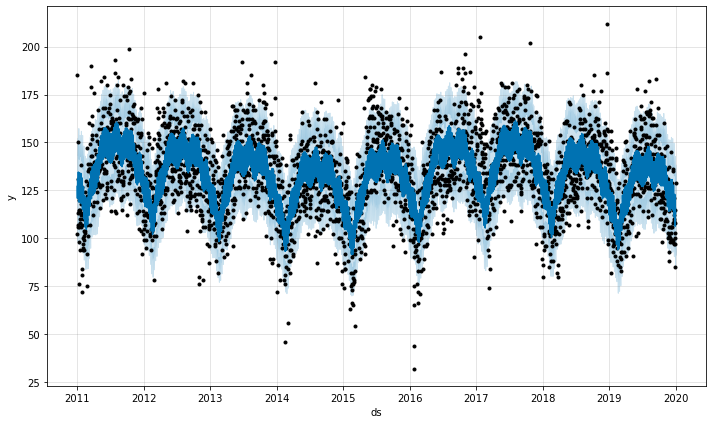

In [5]:
forecast = model.predict()
fig = model.plot(forecast)

## Updating a fitted model

In [6]:
df_yesterday = df[df['ds'] < df['ds'].max()]

In [7]:
model1 = Prophet().fit(df_yesterday)

18:34:04 - cmdstanpy - INFO - Chain [1] start processing
18:34:08 - cmdstanpy - INFO - Chain [1] done processing


In [8]:
model2 = Prophet().fit(df)

18:34:09 - cmdstanpy - INFO - Chain [1] start processing
18:34:14 - cmdstanpy - INFO - Chain [1] done processing


In [9]:
# import numpy as np

# class StanInit:
#     def __init__(self, model):
#         if model.mcmc_samples == 0:
#             self.params = {
#                 'k': model.params['k'][0][0],
#                 'm': model.params['m'][0][0],
#                 'sigma_obs': model.params['sigma_obs'][0][0],
#                 'delta': model.params['delta'][0],
#                 'beta': model.params['beta'][0]
#             }
#         else:
#             self.params = {
#                 'k': np.mean(model.params['k'], axis=0),
#                 'm': np.mean(model.params['m'], axis=0),
#                 'sigma_obs': np.mean(model.params['sigma_obs']),
#                 'delta': np.mean(model.params['delta'], axis=0),
#                 'beta': np.mean(model.params['beta'], axis=0)
#             }
#     def __call__(self):
#         return self.params

import numpy as np

class StanInit:
    def __init__(self, model):
        self.params = {
            'k': np.mean(model.params['k']),
            'm': np.mean(model.params['m']),
            'sigma_obs': np.mean(model.params['sigma_obs']),
            'delta': np.mean(model.params['delta'], axis=0),
            'beta': np.mean(model.params['beta'], axis=0)
        }
    def __call__(self):
        return self.params

In [10]:
model2 = Prophet().fit(
    df,
    inits=StanInit(model1)())

18:34:15 - cmdstanpy - INFO - Chain [1] start processing
18:34:16 - cmdstanpy - INFO - Chain [1] done processing


In [11]:
model1 = Prophet().fit(df)
model2 = Prophet(mcmc_samples=200).fit(
    df,
    inits=StanInit(model1)())

18:34:18 - cmdstanpy - INFO - Chain [1] start processing
18:34:22 - cmdstanpy - INFO - Chain [1] done processing
18:34:24 - cmdstanpy - INFO - CmdStan installation c:\users\gregr\appdata\local\programs\python\python38\lib\site-packages\prophet\stan_model\cmdstan-2.26.1 missing makefile, cannot get version.
18:34:24 - cmdstanpy - INFO - Cannot determine whether version is before 2.28.
18:34:24 - cmdstanpy - INFO - CmdStan start processing
18:34:24 - cmdstanpy - ERROR - Error in progress bar initialization:
	"Unknown argument(s): {'colour': 'yellow'}"
Disabling progress bars for this session
Exception ignored in: <function tqdm.__del__ at 0x000001FE84704AF0>
Traceback (most recent call last):
  File "c:\users\gregr\appdata\local\programs\python\python38\lib\site-packages\tqdm\std.py", line 1086, in __del__
    self.close()
  File "c:\users\gregr\appdata\local\programs\python\python38\lib\site-packages\tqdm\notebook.py", line 244, in close
    if self.total and self.n < self.total:
Attrib

18:49:06 - cmdstanpy - INFO - CmdStan done processing.
18:49:06 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is inf, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is inf, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!


18:49:07 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 2 had 2 iterations at max treedepth (2.0%)
	Use function "diagnose()" to see further information.


## Making interactive plots with Plotly

In [12]:
from datetime import timedelta
import plotly.offline as py
py.init_notebook_mode()

In [13]:
df = pd.read_csv('../data/divvy_daily.csv')
df = df[['date', 'rides', 'temperature']]
df['date'] = pd.to_datetime(df['date'])
df.columns = ['ds', 'y', 'temp']

In [14]:
model = Prophet(seasonality_mode='multiplicative',
                yearly_seasonality=6)
model.add_regressor('temp')

model.fit(df[df['ds'] < df['ds'].max() - timedelta(weeks=2)])

future = model.make_future_dataframe(periods=14)
future['temp'] = df['temp']
forecast = model.predict(future)

18:49:08 - cmdstanpy - INFO - Chain [1] start processing
18:49:09 - cmdstanpy - INFO - Chain [1] done processing


In [15]:
from prophet.plot import (
    plot_plotly,
    plot_components_plotly,
    plot_forecast_component_plotly,
    plot_seasonality_plotly
)

### Plotly forecast plot

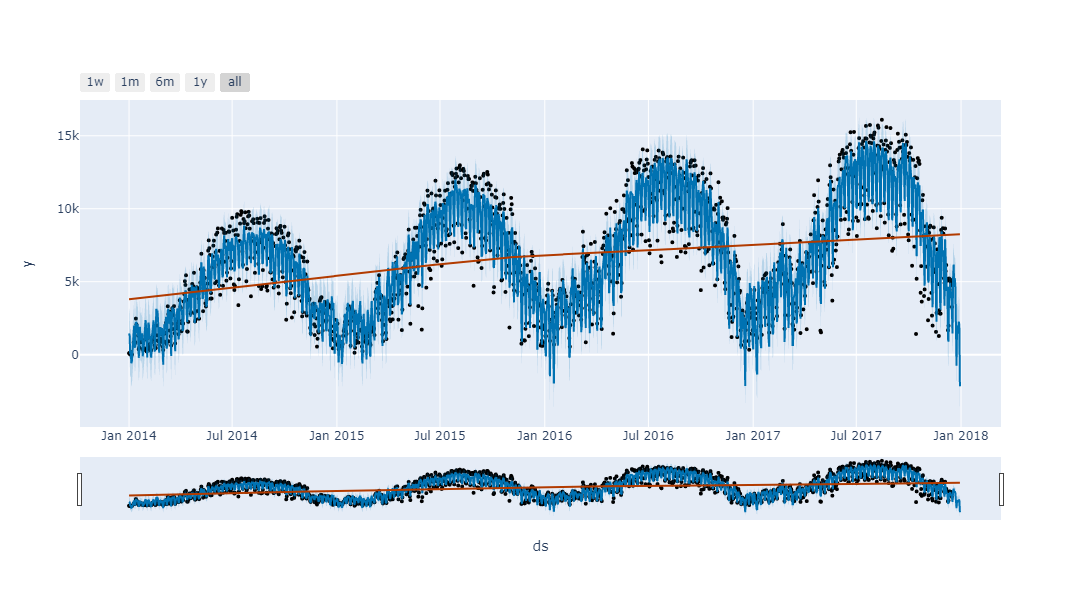

In [16]:
fig = plot_plotly(model, forecast, trend=True)
py.iplot(fig)

### Plotly components plot

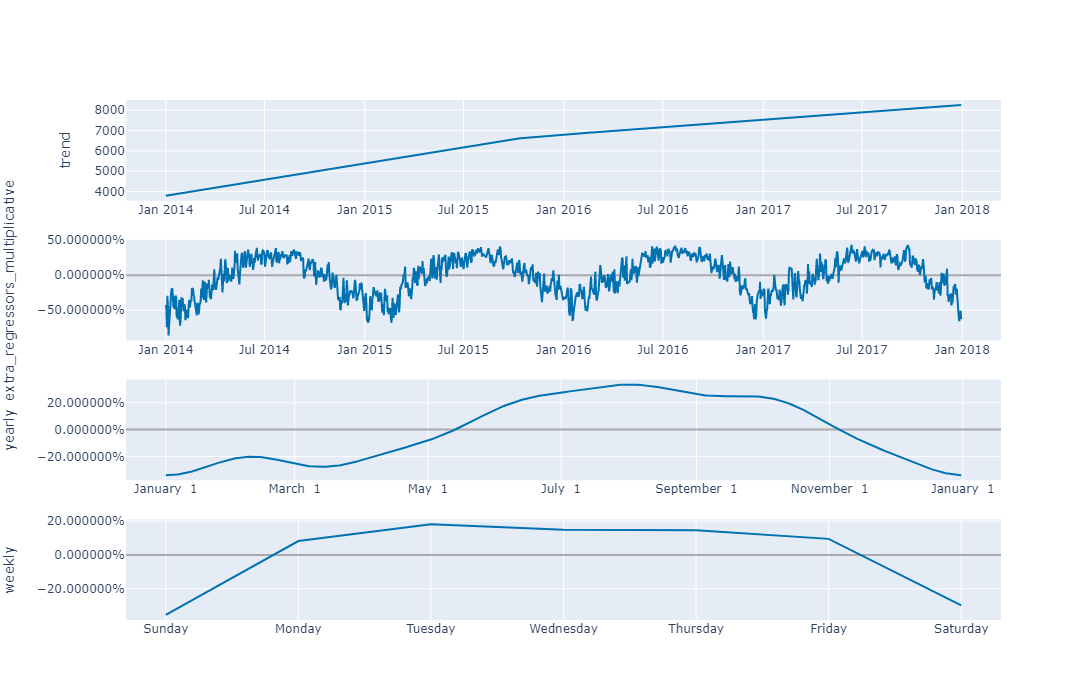

In [17]:
fig = plot_components_plotly(model, forecast , figsize=(800, 175))
py.iplot(fig)

### Plotly single component plot

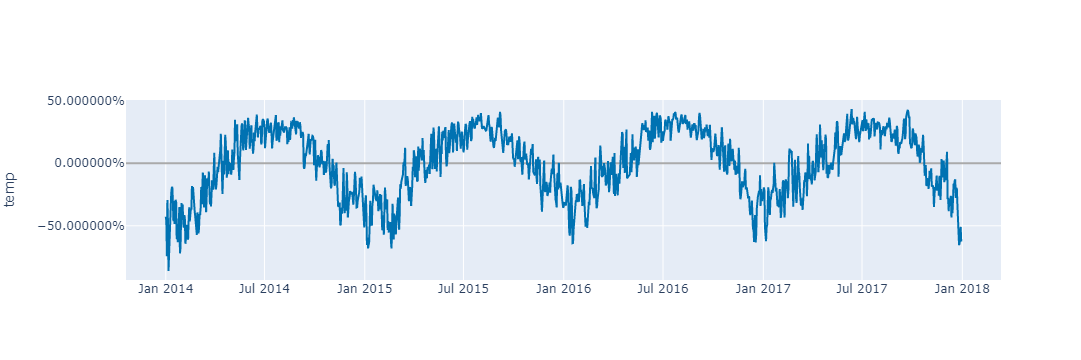

In [18]:
fig = plot_forecast_component_plotly(model, forecast, 'temp')
py.iplot(fig)

### Plotly seasonality plot

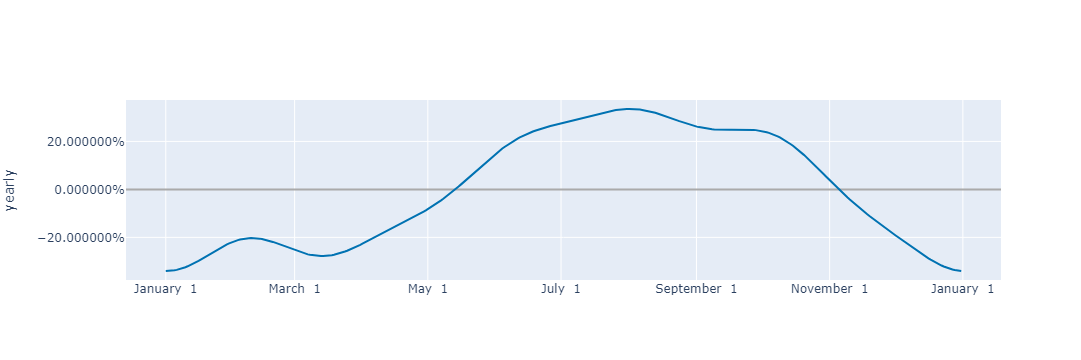

In [19]:
fig = plot_seasonality_plotly(model, 'yearly')
py.iplot(fig)